<a href="https://colab.research.google.com/github/dataforgoodfr/batch7_satellite_ges/blob/master/Find_Peaks_with_LSTM_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Loading Data


In [26]:
import pandas as pd 
%matplotlib inline 
import os 
import numpy as np
import torch
from torch import nn
import copy
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#data_1610 = pd.read_csv("http://courty.fr/OCO2/oco2_1610.csv", sep=";")
#data_1705 = pd.read_csv("http://courty.fr/OCO2/oco2_1705.csv", sep=";")
#data_1803 = pd.read_csv("http://courty.fr/OCO2/oco2_1803.csv", sep=";")
#data_1805 = pd.read_csv("http://courty.fr/OCO2/oco2_1805.csv", sep=";")
data_1808 = pd.read_csv("/content/oco2_1808_light.csv", sep=";")
#data_1809 = pd.read_csv("http://courty.fr/OCO2/oco2_1809.csv", sep=";")

data_1808.head()



,sounding_id,latitude,longitude,xco2,xco2_uncert,orbit,windspeed_u,windspeed_v
0,2018080100462105,-33.015541,-164.508881,405.143188,0.491368,21709,3.749916,9.128431
1,2018080100462137,-32.988529,-164.553787,404.893677,0.497189,21709,3.720200,9.087859
2,2018080100462171,-32.996235,-164.435699,404.729431,0.537358,21709,3.815527,9.151507
3,2018080100462172,-32.992409,-164.455872,404.819550,0.498803,21709,3.799832,9.138914
4,2018080100462173,-32.988403,-164.476196,404.706451,0.496855,21709,3.783962,9.126184


In [0]:
train = data_1808[0:10000]
test = data_1808[10000:11000]
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

def createDataset(df,timeStep=30):
  Xs, ys = [], []

  for i in range(len(train) - TIME_STEPS):
      v = train[['xco2']].iloc[i:(i + TIME_STEPS)].values
      #y = train.iloc[i+TIME_STEPS, train.columns.get_loc('xco2')]
      v = torch.tensor(v).float() 
      
      Xs.append(v)
  
  return torch.stack(Xs)






In [0]:
X_train = createDataset(train)
X_test = createDataset(test)

In [0]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)


    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [0]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [0]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [0]:
def train_model(model, train_dataset, val_dataset, optimizer, start_epoch, n_epochs):
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in tqdm(range(start_epoch, n_epochs + 1)):
    
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    #if val_loss < best_loss:
     # best_loss = val_loss
     # best_model_wts = copy.deepcopy(model.state_dict())
    savePath = "/content/drive/My Drive/classifier.pt" 

    checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
    torch.save(checkpoint, savePath)
    
    print('Epoch {0}: train loss {1} val loss {2}'.format(epoch, train_loss,val_loss))



  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [0]:
savePath = "/content/drive/My Drive/classifier.pt" 

model = RecurrentAutoencoder(30, 1, 128)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

model, history = train_model(
  model,
  X_train,
  X_test,
  optimizer,
  checkpoint['epoch'],
  n_epochs=1000
)




  0%|          | 0/997 [00:00<?, ?it/s]


  0%|          | 1/997 [01:51<30:50:59, 111.51s/it]

Epoch 4: train loss 272.9881053193761 val loss 267.107117048166





  0%|          | 2/997 [03:45<30:59:44, 112.14s/it]

Epoch 5: train loss 258.96917015083335 val loss 253.2745945768825





  0%|          | 3/997 [05:38<31:05:06, 112.58s/it]

Epoch 6: train loss 245.32367397296872 val loss 239.8156703631402





  0%|          | 4/997 [07:32<31:07:52, 112.86s/it]

Epoch 7: train loss 232.0514319524124 val loss 226.7300840341459





  1%|          | 5/997 [09:24<31:04:13, 112.76s/it]

Epoch 8: train loss 219.1523270296118 val loss 214.01765236046273





  1%|          | 6/997 [11:16<30:58:42, 112.54s/it]

Epoch 9: train loss 206.62631548362128 val loss 201.6782862564745





  1%|          | 7/997 [13:08<30:51:03, 112.19s/it]

Epoch 10: train loss 194.47350493864406 val loss 189.71211965210819





  1%|          | 8/997 [14:58<30:40:58, 111.69s/it]

Epoch 11: train loss 182.69369399703015 val loss 178.11878611756902





  1%|          | 9/997 [16:49<30:36:17, 111.52s/it]

Epoch 12: train loss 171.2869758996227 val loss 166.89852856298387





  1%|          | 10/997 [18:39<30:23:39, 110.86s/it]

Epoch 13: train loss 160.25346397774868 val loss 156.0515534518595





  1%|          | 11/997 [20:28<30:12:51, 110.32s/it]

Epoch 14: train loss 149.59260222225515 val loss 145.57703304539473





  1%|          | 12/997 [22:17<30:06:58, 110.07s/it]

Epoch 15: train loss 139.3054179261417 val loss 135.4767379538824





  1%|▏         | 13/997 [24:06<29:59:53, 109.75s/it]

Epoch 16: train loss 129.39159712490132 val loss 125.74949973822835





  1%|▏         | 14/997 [25:54<29:50:35, 109.29s/it]

Epoch 17: train loss 119.85021095161093 val loss 116.39406912219202





  2%|▏         | 15/997 [27:42<29:40:23, 108.78s/it]

Epoch 18: train loss 110.68092518063223 val loss 107.41094757814705





  2%|▏         | 16/997 [29:30<29:32:34, 108.41s/it]

Epoch 19: train loss 101.88406189867821 val loss 98.80047551559709





  2%|▏         | 17/997 [31:17<29:25:09, 108.07s/it]

Epoch 20: train loss 93.45968186006384 val loss 90.56186467957951





  2%|▏         | 18/997 [33:04<29:21:26, 107.95s/it]

Epoch 21: train loss 85.40756280223728 val loss 82.69594926288876





  2%|▏         | 19/997 [34:52<29:16:39, 107.77s/it]

Epoch 22: train loss 77.72780175778189 val loss 75.20210654508386





  2%|▏         | 20/997 [36:40<29:14:23, 107.74s/it]

Epoch 23: train loss 70.42019310265391 val loss 68.08039228502463





  2%|▏         | 21/997 [38:28<29:15:46, 107.94s/it]

Epoch 24: train loss 63.484243244106096 val loss 61.330292739026405





  2%|▏         | 22/997 [40:16<29:12:29, 107.85s/it]

Epoch 25: train loss 56.92043141256962 val loss 54.9526181158833





  2%|▏         | 23/997 [42:03<29:10:53, 107.86s/it]

Epoch 26: train loss 50.72877567256824 val loss 48.94691856636805





  2%|▏         | 24/997 [43:51<29:07:09, 107.74s/it]

Epoch 27: train loss 44.90865908616046 val loss 43.311993650017435





  3%|▎         | 25/997 [45:38<29:01:49, 107.52s/it]

Epoch 28: train loss 39.45973598438137 val loss 38.04910105032811





  3%|▎         | 26/997 [47:25<28:58:19, 107.41s/it]

Epoch 29: train loss 34.38214179300138 val loss 33.15630118811023





  3%|▎         | 27/997 [49:12<28:55:32, 107.35s/it]

Epoch 30: train loss 29.67402923511287 val loss 28.632525552120228





  3%|▎         | 28/997 [51:00<28:55:42, 107.47s/it]

Epoch 31: train loss 25.335150666461665 val loss 24.477902302411998





  3%|▎         | 29/997 [52:47<28:53:48, 107.47s/it]

Epoch 32: train loss 21.365569118511235 val loss 20.693090500635513





  3%|▎         | 30/997 [54:35<28:53:21, 107.55s/it]

Epoch 33: train loss 17.764615890039963 val loss 17.275293315114563





  3%|▎         | 31/997 [56:23<28:51:29, 107.55s/it]

Epoch 34: train loss 14.52999540011407 val loss 14.223251417001247





  3%|▎         | 32/997 [58:11<28:50:49, 107.62s/it]

Epoch 35: train loss 11.659833862119118 val loss 11.534249849089887





  3%|▎         | 33/997 [59:59<28:53:05, 107.87s/it]

Epoch 36: train loss 9.151617958122413 val loss 9.204955803307751





  3%|▎         | 34/997 [1:01:47<28:51:15, 107.87s/it]

Epoch 37: train loss 6.999915254319324 val loss 7.229641791977878


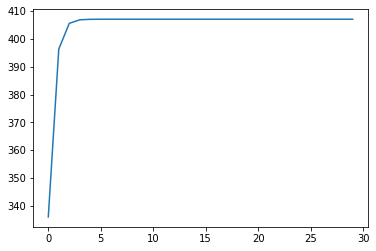

In [25]:
import matplotlib.pyplot as plt
model(X_train[1].to(device))
plt.plot(model(X_train[1].to(device)).cpu().detach().numpy())

In [0]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.MSELoss().to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [0]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [0]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')